In [2]:
pip install fbprophet

  Using cached fbprophet-0.7.1.tar.gz (64 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached Cython-3.0.12-cp312-cp312-win_amd64.whl.metadata (3.6 kB)
  Using cached cmdstanpy-0.9.5-py3-none-any.whl.metadata (2.9 kB)
  Using cached pystan-3.10.0-py3-none-any.whl.metadata (3.7 kB)
  Using cached LunarCalendar-0.0.9-py2.py3-none-any.whl.metadata (6.3 kB)
  Using cached convertdate-2.4.0-py3-none-any.whl.metadata (8.3 kB)
  Using cached setuptools_git-1.2-py2.py3-none-any.whl.metadata (5.8 kB)
  Using cached PyMeeus-0.5.12.tar.gz (5.8 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached ephem-4.2-cp312-cp312-win_amd64.whl.metadata (6.4 kB)
  Using cached clikit-0.6.2-py2.py3-none-any.whl.metadata (1.6 kB)
INFO: pip is looking at multiple versions of pystan to determine which version is compatible with other requirements. This could take a while.
  Using

  error: subprocess-exited-with-error
  
  python setup.py egg_info did not run successfully.
  exit code: 1
  
  [6 lines of output]
  Traceback (most recent call last):
    File "<string>", line 2, in <module>
    File "<pip-setuptools-caller>", line 34, in <module>
    File "C:\Users\thota\AppData\Local\Temp\pip-install-4munvsio\pystan_db5614ee9d8f4e93bcc1ea7dff66bef7\setup.py", line 122, in <module>
      from Cython.Build.Inline import _get_build_extension
  ModuleNotFoundError: No module named 'Cython'
  [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

Encountered error while generating package metadata.

See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from prophet import Prophet

In [4]:
# Load dataset
data = pd.read_csv('dataset.csv')

In [5]:
# Inspect dataset
print(data.info())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2106 entries, 0 to 2105
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             2106 non-null   object 
 1   demand           2106 non-null   float64
 2   RRP              2106 non-null   float64
 3   demand_pos_RRP   2106 non-null   float64
 4   RRP_positive     2106 non-null   float64
 5   demand_neg_RRP   2106 non-null   float64
 6   RRP_negative     2106 non-null   float64
 7   frac_at_neg_RRP  2106 non-null   float64
 8   min_temperature  2106 non-null   float64
 9   max_temperature  2106 non-null   float64
 10  solar_exposure   2105 non-null   float64
 11  rainfall         2103 non-null   float64
 12  school_day       2106 non-null   object 
 13  holiday          2106 non-null   object 
dtypes: float64(11), object(3)
memory usage: 230.5+ KB
None
         date      demand        RRP  demand_pos_RRP  RRP_positive  \
0  2015-01-01   99635.030  

In [6]:
# Preserve 'date' column for later use
if 'date' in data.columns:
    date_column = pd.to_datetime(data['date'])

In [7]:
# Handle missing values
imputer = SimpleImputer(strategy='median')
num_cols = data.select_dtypes(include=[np.number]).columns
data[num_cols] = imputer.fit_transform(data[num_cols])

In [8]:
# Convert school days and holidays to binary
if 'school_day' in data.columns and 'holiday' in data.columns:
    data['is_school_day'] = data['school_day'].apply(lambda x: 1 if x == 'Y' else 0)
    data['is_holiday'] = data['holiday'].apply(lambda x: 1 if x == 'Y' else 0)
    data.drop(columns=['school_day', 'holiday'], inplace=True)

In [9]:
# Feature Engineering - Extract time-based features
data['date'] = pd.to_datetime(data['date'])
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['day_of_week'] = data['date'].dt.weekday
data['week_of_year'] = data['date'].dt.isocalendar().week

In [10]:
# Identify and encode categorical variables
cat_features = data.select_dtypes(include=['object']).columns.tolist()
if 'date' in cat_features:
    cat_features.remove('date')

if cat_features:
    encoder = OneHotEncoder(sparse_output=False, drop='first')
    encoded = encoder.fit_transform(data[cat_features])
    encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(cat_features))
    data = pd.concat([data, encoded_df], axis=1)
    data.drop(columns=cat_features, inplace=True)

In [11]:
# Outlier detection using Isolation Forest
iso_forest = IsolationForest(contamination=0.01, random_state=42)
outliers = iso_forest.fit_predict(data.select_dtypes(include=[np.number]))
data = data[outliers == 1]

In [12]:
# Prepare data for models
cleaned_data = data.copy()
print(f'Cleaned dataset shape: {cleaned_data.shape}')

Cleaned dataset shape: (2084, 19)


In [13]:
# XGBoost Model
X = cleaned_data.drop(columns=['date', 'demand'])
y = cleaned_data['demand']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

xgb_model = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)

mae_xgb = mean_absolute_error(y_test, xgb_predictions)
rmse_xgb = np.sqrt(mean_squared_error(y_test, xgb_predictions))

print(f"XGBoost Model - MAE: {mae_xgb}, RMSE: {rmse_xgb}")

XGBoost Model - MAE: 240.74084307553878, RMSE: 791.3578000285867


In [14]:
# Prepare data for Prophet
prophet_data = cleaned_data[['date', 'demand']].rename(columns={'date': 'ds', 'demand': 'y'})

In [15]:
# Train Prophet Model
train_data, test_data = train_test_split(prophet_data, test_size=0.2, random_state=42, shuffle=False)
prophet_model = Prophet(growth='linear', seasonality_mode='additive', yearly_seasonality=True, weekly_seasonality=True)
prophet_model.fit(train_data)

16:53:05 - cmdstanpy - INFO - Chain [1] start processing
16:53:05 - cmdstanpy - INFO - Chain [1] done processing


In [16]:
# Forecast future
future = prophet_model.make_future_dataframe(periods=len(test_data), freq='D')
forecast = prophet_model.predict(future)

In [17]:
# Evaluate Prophet
y_true = test_data['y'].values
y_pred = forecast['yhat'][-len(test_data):].values

mae_prophet = mean_absolute_error(y_true, y_pred)
rmse_prophet = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"Prophet Model - MAE: {mae_prophet}, RMSE: {rmse_prophet}")

Prophet Model - MAE: 8855.164117147942, RMSE: 11596.40953452473


             ds           yhat     yhat_lower     yhat_upper
1692 2019-08-29  129813.867081  118861.107811  140049.897083
1693 2019-08-30  127186.000128  115895.656645  138500.402310
1694 2019-08-31  114237.655442  103815.359875  125570.342612
1695 2019-09-01  109780.600344   98723.244684  120969.611168
1696 2019-09-02  124470.279677  113575.418635  135635.104791


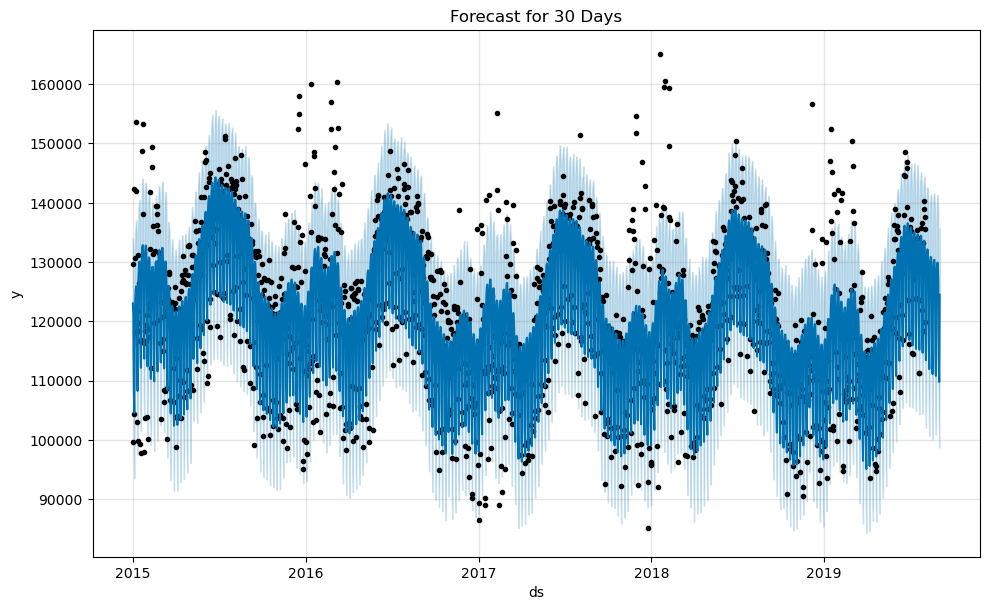

In [22]:
def forecast_future_days(model, days=30):
    # Ensure the model is trained
    if not hasattr(model, 'history'):
        print("Error: Prophet model is not trained yet.")
        return
    
    # Generate future dates and forecast
    future_dates = model.make_future_dataframe(periods=days, freq='D')
    future_forecast = model.predict(future_dates)
    
    # Display forecasted values
    print(future_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())
    
    # Plot the forecast
    model.plot(future_forecast)
    plt.title(f"Forecast for {days} Days")
    plt.show()

# Usage
forecast_future_days(prophet_model, days=30)

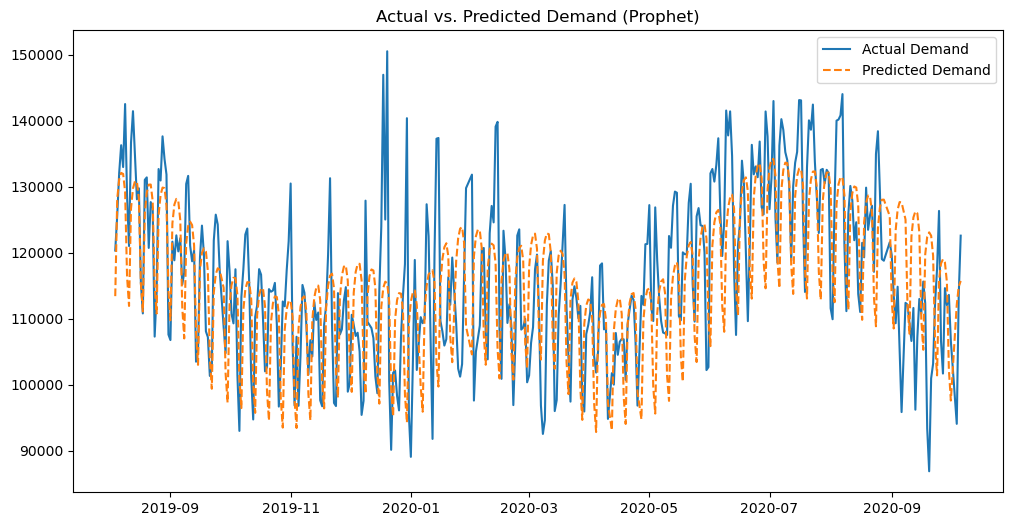

In [19]:
# Visualize actual vs. predicted
plt.figure(figsize=(12, 6))
plt.plot(test_data['ds'], y_true, label='Actual Demand')
plt.plot(test_data['ds'], y_pred, label='Predicted Demand', linestyle='--')
plt.title('Actual vs. Predicted Demand (Prophet)')
plt.legend()
plt.show()